<a href="https://colab.research.google.com/github/vkthakur90/Econometrics/blob/main/ARIMA_GARCH_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("quantmod", repos = "https://cran.r-project.org")
install.packages("rugarch", repos = "https://cran.r-project.org")
install.packages("forecast", repos = "https://cran.r-project.org")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "AAPL"

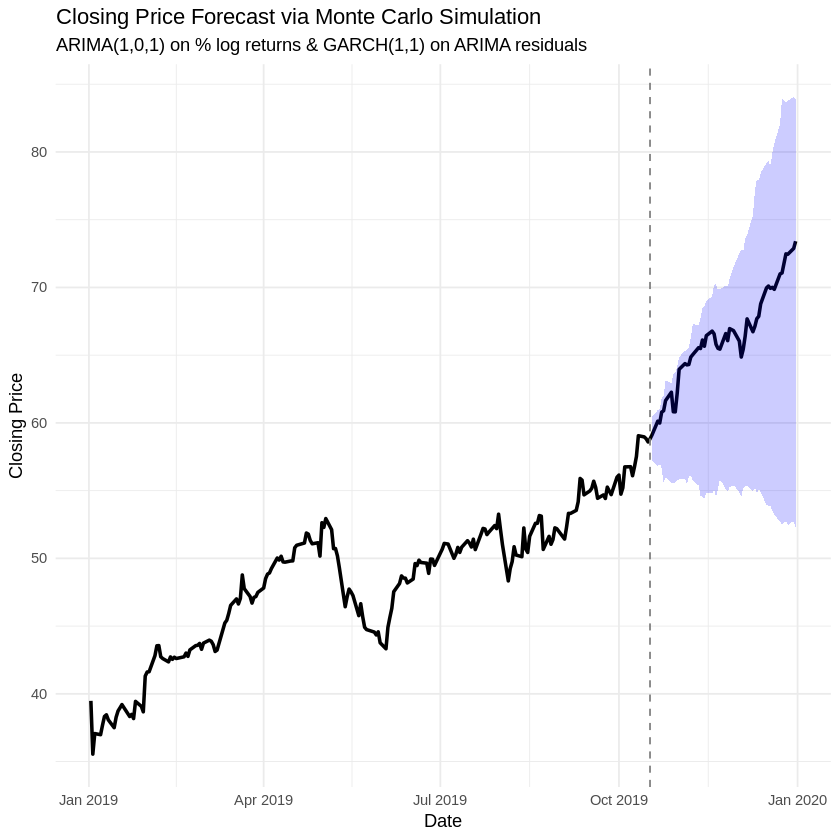

In [4]:
# Suppress xts lag warning from dplyr
options(xts.warn_dplyr_breaks_lag = FALSE)

# Load libraries
library(quantmod)    # For downloading stock data
library(forecast)    # For ARIMA modeling and forecasting
library(rugarch)     # For GARCH modeling
library(ggplot2)     # For plotting
library(dplyr)       # For data manipulation
library(magrittr)    # For the pipe operator
library(tidyr)       # For reshaping data
library(tibble)      # For tibble conversion

# 1. Download stock price data (Apple Inc. "AAPL")
symbol <- "AAPL"
start_date <- "2019-01-01"
end_date <- "2020-01-01"
getSymbols(symbol, src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)
prices <- Cl(get(symbol))

# 2. Compute percentage log returns using a pipeline
returns <- prices %>%
  log() %>%
  diff() %>%
  `*`(100) %>%
  na.omit()

# 3. Split data into training (80%) and testing (20%) sets
n <- length(returns)
train_size <- floor(0.8 * n)
train_returns <- returns[1:train_size]
test_returns  <- returns[(train_size + 1):n]

# 4. Fit ARIMA(1,0,1) on training returns and extract residuals
arima_fit <- arima(train_returns, order = c(1, 0, 1))
arima_resid <- residuals(arima_fit)

# 5. Fit GARCH(1,1) on ARIMA residuals
garch_spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
  mean.model     = list(armaOrder = c(0, 0), include.mean = TRUE),
  distribution.model = "norm"
)
garch_fit <- ugarchfit(spec = garch_spec, data = arima_resid)

# 6. Forecast on the test period
forecast_horizon <- length(test_returns)
arima_forecast <- forecast(arima_fit, h = forecast_horizon)
forecast_returns <- as.numeric(arima_forecast$mean)
garch_forecast <- ugarchforecast(garch_fit, n.ahead = forecast_horizon)
sigma_forecast <- sigma(garch_forecast)

# 7. Monte Carlo Simulation to generate future price paths
N_sim <- 100  # Total simulation paths
H <- forecast_horizon
sim_matrix <- matrix(NA, nrow = H, ncol = N_sim)
last_train_price <- as.numeric(prices[train_size + 1])  # Starting price for simulation

for (i in 1:N_sim) {
  sim_returns <- sapply(1:H, function(j) {
    rnorm(1, mean = forecast_returns[j], sd = sigma_forecast[j])
  })
  sim_matrix[, i] <- last_train_price * exp(cumsum(sim_returns / 100))
}

# 8. Compute 95% confidence envelope (2.5% and 97.5% quantiles) from all simulations
lower_bound <- apply(sim_matrix, 1, quantile, probs = 0.025)
upper_bound <- apply(sim_matrix, 1, quantile, probs = 0.975)

# 9. Prepare tidy data frames for plotting
df_actual <- tibble(Date = index(prices),
                    Price = as.numeric(prices))

# Convert simulation matrix to a tidy data frame and select a few (e.g., 5) paths
df_sim <- sim_matrix %>%
  as.data.frame() %>%
  rownames_to_column(var = "Index") %>%
  mutate(Index = as.numeric(Index),
         Date = index(test_returns)[Index]) %>%
  pivot_longer(cols = -c(Index, Date), names_to = "Simulation", values_to = "Price") %>%
  filter(Simulation %in% paste0(1:5))

df_envelope <- tibble(Date = index(test_returns),
                      Lower = lower_bound,
                      Upper = upper_bound)

# 10. Plot only the final output: Actual prices, selected Monte Carlo paths, and 95% CI envelope
ggplot() +
  geom_line(data = df_actual, aes(x = Date, y = Price), color = "black", size = 1) +
  geom_ribbon(data = df_envelope, aes(x = Date, ymin = Lower, ymax = Upper), fill = "blue", alpha = 0.2) +
  geom_line(data = df_sim, aes(x = Date, y = Price, group = Simulation), color = "blue", alpha = 0.6) +
  geom_vline(xintercept = index(prices)[train_size + 1], linetype = "dashed", color = "grey50") +
  labs(title = "Closing Price Forecast via Monte Carlo Simulation",
       subtitle = "ARIMA(1,0,1) on % log returns & GARCH(1,1) on ARIMA residuals",
       x = "Date", y = "Closing Price") +
  theme_minimal()
